In [1]:
#@title Initial Colab setup...

# remove colab sample_data
!rm -rf sample_data/

# download datasets
!rm -rf /tmp/sf-lab; git clone https://github.com/sysflow-telemetry/sf-lab.git /tmp/sf-lab

# add symlink to working directory
!unlink data; ln -s /tmp/sf-lab/pynb/data data
!unlink policies; ln -s /tmp/sf-lab/pynb/policies policies

# install sysflow tooling
!pip install sysflow-tools==0.5.1rc4

Cloning into '/tmp/sf-lab'...
remote: Enumerating objects: 152, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 152 (delta 10), reused 17 (delta 6), pack-reused 131
Receiving objects: 100% (152/152), 14.90 MiB | 2.02 MiB/s, done.
Resolving deltas: 100% (78/78), done.
unlink: cannot unlink 'data': Is a directory
ln: failed to create symbolic link 'data/data': File exists
unlink: cannot unlink 'policies': Is a directory
ln: failed to create symbolic link 'policies/policies': File exists
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: sysflow-tools
    Found existing installation: sysflow-tools 0.6.1
    Uninstalling sysflow-tools-0.6.1:
      Successfully uninstalled sysflow-tools-0.6.1


In [2]:
import sys, os, json
import numpy as np
import pandas as pd
from sysflow.graphlet import Graphlet
from sysflow.reader import FlattenedSFReader
from sysflow.formatter import SFFormatter
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)
pd.set_option('display.max_columns', None)
cols=['ts_uts', 'endts_uts', 'type', 'opflags', 'proc.pid', 'proc.tid', 'pproc.pid', 'proc.exe', 'proc.args', 'pproc.exe', 'pproc.args', 'res', 'flow.rbytes', 'flow.rops', 'flow.wbytes', 'flow.wops', 'container.id', 'tags']
_cols=['ts_uts', 'type', 'opflags', 'proc.pid', 'proc.tid', 'pproc.pid', 'proc.exe', 'proc.args', 'pproc.exe', 'tags']
evtcols=['ts_uts', 'type', 'opflags', 'proc.pid', 'pproc.pid', 'proc.exe', 'proc.args', 'pproc.exe', 'pproc.args', 'container.id', 'tags']
entry='proc.aname contains /bin/bash'
_entry='proc.aname contains apache2'

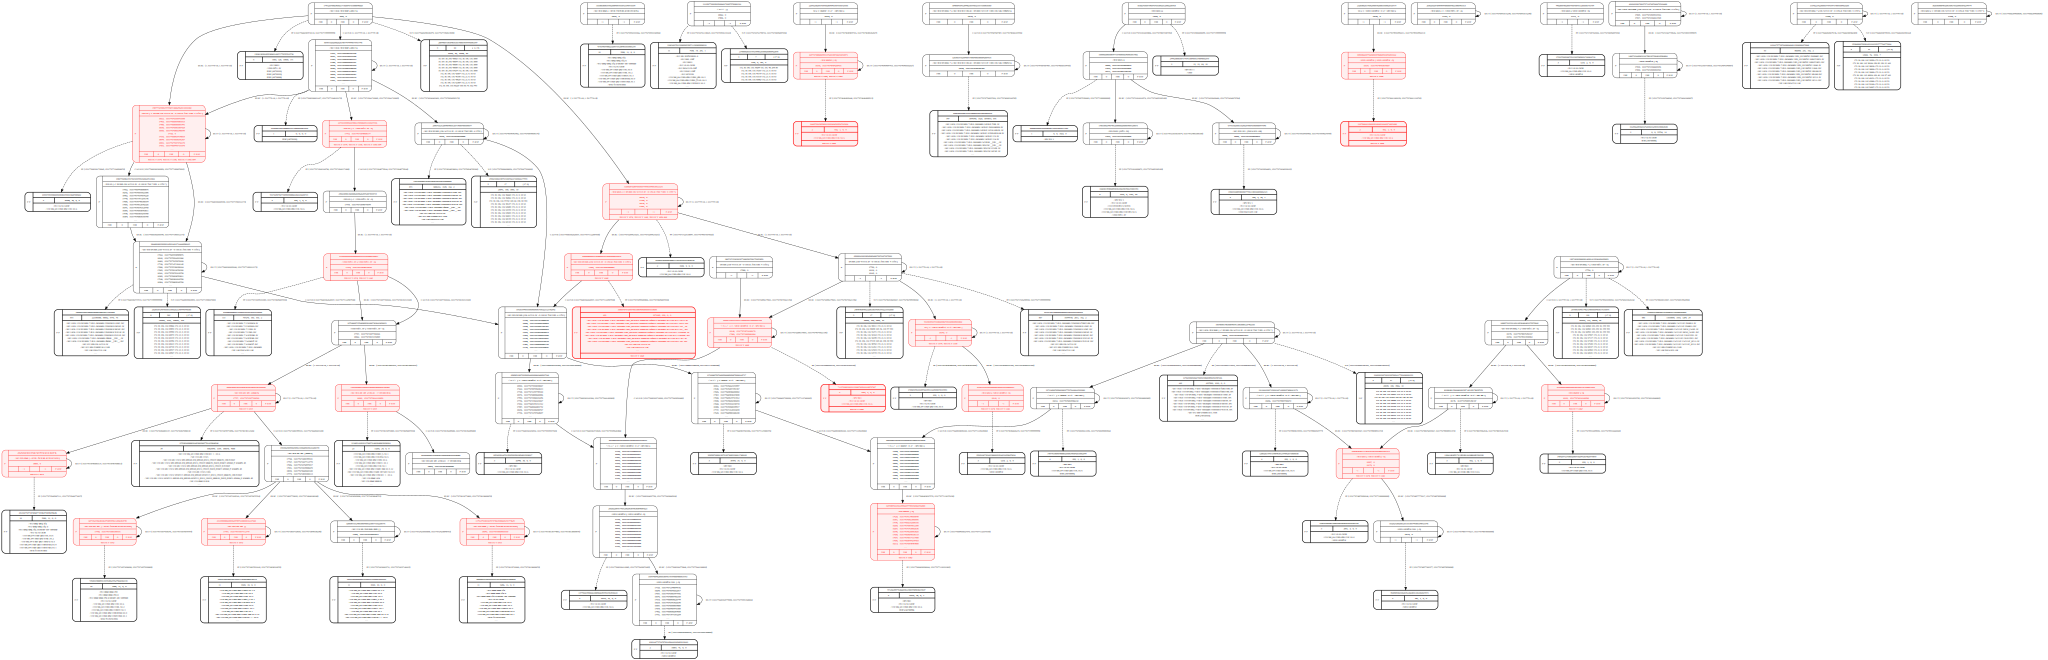

In [3]:
# graphlet showing client2's node.js server exploit with TTP tagging.
ioc = '(proc.cmdline contains exfil or (type = FF and file.path contains exfil and flow.wbytes > 0)) and proc.aname contains node and proc.exe!=/bin/dash'
gn = Graphlet('data/attacks/express',defs=['policies/ttps.yaml']) #Graphlet(<file>, ['policies/ttps.yaml'])
gn.view(withoid=True, peek=True, peeksize=10, flows=True, ttps=True)

In [5]:
_ioc = 'proc.cmdline contains exfil or proc.aname contains exfil'
gm = Graphlet('data/attacks/express/1711486262',defs = ['policies/ttps.yaml'])
gm.data()[_cols]

,ts_uts,type,opflags,proc.pid,proc.tid,pproc.pid,proc.exe,proc.args,pproc.exe,tags
0,1.711486e+18,FF,C,176679,176679.0,176678,/bin/mkdir,-p /var/run/apache2,/usr/sbin/apache2ctl,()
1,1.711486e+18,FF,C,176679,176679.0,176678,/bin/mkdir,-p /var/run/apache2,/usr/sbin/apache2ctl,()
2,1.711486e+18,PE,EXIT,176679,176679.0,176678,/bin/mkdir,-p /var/run/apache2,/usr/sbin/apache2ctl,()
3,1.711486e+18,PE,CLONE,176680,176680.0,176678,/usr/sbin/apache2ctl,/usr/sbin/apache2ctl -DFOREGROUND,/usr/sbin/apache2ctl,()
4,1.711486e+18,FF,O C,176680,176680.0,176678,/usr/sbin/apache2ctl,/usr/sbin/apache2ctl -DFOREGROUND,/usr/sbin/apache2ctl,()
...,...,...,...,...,...,...,...,...,...,...
180,1.711486e+18,PE,EXIT,176687,176687.0,176686,/usr/sbin/apache2,-DFOREGROUND,/usr/sbin/apache2,()
181,NaN,P,,176679,NaN,176678,/bin/mkdir,-p /var/run/apache2,/usr/sbin/apache2ctl,()
182,NaN,P,,176678,NaN,176655,/usr/sbin/apache2ctl,/usr/sbin/apache2ctl -DFOREGROUND,/main.sh,()
183,NaN,P,,176688,NaN,176686,/usr/sbin/apache2,-DFOREGROUND,/usr/sbin/apache2,()


In [7]:
# Here we use the tags to retrieve the corresponding technique, tactics, etc. from MITRE via STIX/TAXII. 
gn.ttps()

,ID,name,url,tactics,platforms
0,T1574,Hijack Execution Flow,https://attack.mitre.org/techniques/T1574,"Defense Evasion, Persistence, Privilege Escalation","Linux, Windows, macOS"
1,T1106,Native API,https://attack.mitre.org/techniques/T1106,Execution,"Linux, Windows, macOS"
2,T1059.004,Command and Scripting Interpreter: Unix Shell,https://attack.mitre.org/techniques/T1059/004,Execution,"Linux, macOS"
3,T1068,Exploitation for Privilege Escalation,https://attack.mitre.org/techniques/T1068,Privilege Escalation,"Containers, Linux, Windows, macOS"
4,T1082,System Information Discovery,https://attack.mitre.org/techniques/T1082,Discovery,"IaaS, Linux, Network, Windows, macOS"
5,T1072,Software Deployment Tools,https://attack.mitre.org/techniques/T1072,"Execution, Lateral Movement","Linux, Network, Windows, macOS"


In [8]:
ttps = gn.data()[_cols]
ttps[ttps.tags != ()]

,ts_uts,type,opflags,proc.pid,proc.tid,pproc.pid,proc.exe,proc.args,pproc.exe,tags
76,1531776683301636352.0,PE,EXEC,17459,17459.0,2025,/bin/sh,"-c python cos-write.py -p testat:foo:""ibm 4 life!""",/usr/local/bin/node,"([Suspiciousprocessspawned, Shellstartedbycontainerentrypoint], {mitre:T1574, mitre:T1106, mitre:T1059.004}, 3)"
537,1531776683644972032.0,PE,EXEC,17463,17463.0,2025,/bin/sh,"-c python cos-write.py -p testat:foo:""ibm 4 life!""",/usr/local/bin/node,"([Suspiciousprocessspawned, Shellstartedbycontainerentrypoint], {mitre:T1574, mitre:T1106, mitre:T1059.004}, 3)"
1376,1531776684038327570,PE,EXEC,17468,17468,17467,/bin/uname,-p,<NA>,"([SystemInformationDiscovery], {mitre:T1082}, 3)"
1860,1531776684422695748,PE,EXEC,17471,17471,17470,/bin/uname,-p,<NA>,"([SystemInformationDiscovery], {mitre:T1082}, 3)"
1970,1531776685507394816.0,PE,EXEC,17485,17485.0,2025,/bin/sh,"-c python cos-write.py -p testat:foo:""ibm 4 life!""",/usr/local/bin/node,"([Suspiciousprocessspawned, Shellstartedbycontainerentrypoint], {mitre:T1574, mitre:T1106, mitre:T1059.004}, 3)"
...,...,...,...,...,...,...,...,...,...,...
41162,1531776768833592064.0,PE,EXEC,18383,18383.0,2025,/bin/sh,"-c python cos-write.py -p testat:foo:""ibm 4 life!""",/usr/local/bin/node,"([Suspiciousprocessspawned, Shellstartedbycontainerentrypoint], {mitre:T1574, mitre:T1106, mitre:T1059.004}, 3)"
42024,1531776769582382258,PE,EXEC,18389,18389,18388,/bin/uname,-p,<NA>,"([SystemInformationDiscovery], {mitre:T1082}, 3)"
42132,1531776770374935040.0,PE,EXEC,18401,18401.0,2025,/bin/sh,"-c python cos-write.py -p testat:foo:""ibm 4 life!""",/usr/local/bin/node,"([Suspiciousprocessspawned, Shellstartedbycontainerentrypoint], {mitre:T1574, mitre:T1106, mitre:T1059.004}, 3)"
42977,1531776771125172293,PE,EXEC,18410,18410,18409,/bin/uname,-p,<NA>,"([SystemInformationDiscovery], {mitre:T1082}, 3)"


In [9]:
# Here we summarize the unique set of mitigations corresponding to the ttps oberved in graphlet.
gn.mitigations()

,ID,name,url
0,M1013,Application Developer Guidance,https://attack.mitre.org/mitigations/M1013
1,M1047,Audit,https://attack.mitre.org/mitigations/M1047
2,M1040,Behavior Prevention on Endpoint,https://attack.mitre.org/mitigations/M1040
3,M1038,Execution Prevention,https://attack.mitre.org/mitigations/M1038
4,M1022,Restrict File and Directory Permissions,https://attack.mitre.org/mitigations/M1022
5,M1044,Restrict Library Loading,https://attack.mitre.org/mitigations/M1044
6,M1024,Restrict Registry Permissions,https://attack.mitre.org/mitigations/M1024
7,M1051,Update Software,https://attack.mitre.org/mitigations/M1051
8,M1052,User Account Control,https://attack.mitre.org/mitigations/M1052
9,M1018,User Account Management,https://attack.mitre.org/mitigations/M1018


In [19]:
trace="data/attacks/express/1711486262"
reader = FlattenedSFReader(trace)
formatter = SFFormatter(reader)
cdf = formatter.toDataframe()
cdf.loc[cdf['container.name'] == 'wcm-app', 'container.name'] = 'app'
cdf.loc[cdf['container.name'] == 'wcm-squid', 'container.name'] = 'node.js'

In [20]:
container_type =  cdf.groupby(['container.name','proc.exe','proc.args','pproc.exe','type','res']).size().reset_index(name='count')
cluster = px.treemap(container_type, path=['container.name','proc.exe','type','res'], values='count',
                  color='type', 
                  hover_data=['container.name','proc.exe','proc.args','pproc.exe','type','res'], 
                  color_discrete_sequence=px.colors.qualitative.Plotly)  

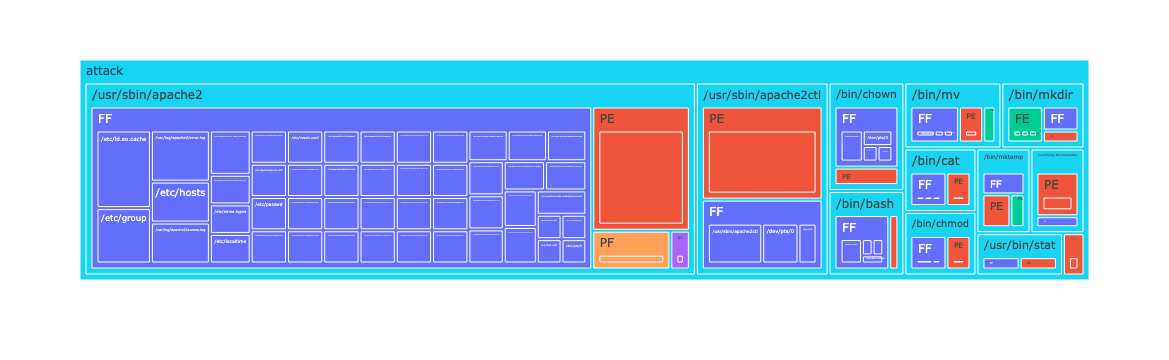

In [21]:
cluster.show()

In [24]:
dn = formatter.toDataframe()

0

In [26]:
containerNF = dn[(dn['type'].isin(['NF']))]
containerNF =  containerNF.groupby(['container.name','net.sport','net.sip','net.dport', 'net.dip']).size().reset_index(name='count')
containerNF.loc[containerNF['net.sport'] > 40000, 'net.sport'] = 40001
containerNF['net.sport'] = containerNF['net.sport'].mask(containerNF['net.sport'].between(1024, 40000))
containerNF['net.sport'] = containerNF['net.sport'].replace(np.nan, '1024-40000', regex=True)
containerNF['net.sport'] = containerNF['net.sport'].replace(40001, '40001+', regex=True)
nf = px.parallel_categories(containerNF, dimensions=['container.name','net.sport', 'net.sip', 'net.dport', 'net.dip'],
                color="net.dport", color_continuous_scale=px.colors.sequential.PuBuGn
                )

KeyError: 'type'